In [1]:
import numpy as np
import os
from scipy import stats
from scipy.optimize import minimize
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm

## Obtain Data Using API

In [2]:
# Twelve Data API key
api_key = "65326be4c72f486e8bd0df04e7c89e05"
# Type of stock
ticker = "MSFT"
# Data resolution
interval = "1day"
# Length of data to be 1000 days
N=1000

api_url = f"https://api.twelvedata.com/time_series?symbol={ticker}&interval={interval}&outputsize={N}&apikey={api_key}"
data = requests.get(api_url).json()
df=pd.DataFrame(data["values"])
df=df[::-1]
print("Data is obtained")

Data is obtained


## Cleaning Data and Calculate Return

In [3]:
# Change data type to float
for col in df.columns:
    try:
        df[col]=df[col].astype(float)
    except:
        pass
print("Data is now numeric")

Data is now numeric


In [4]:
## Calculate daily return
Return=np.array( ( df["close"]-df["open"] )/df["open"] )

## Implementation of Hidden Markov Model

In this model, the daily return $R[t]$ is assumed to be mean 0 normal with varying standard deviation $\sigma_t$ following an exponentiated random walk:

$$R[t] \sim N(0,\sigma_t) $$

$$ \sigma_t = \sigma_0e^{\alpha W_t} $$

Here $W_t$ is a random walk starting at 0, $\alpha$ and $\sigma_0$ are model parameters that need to be estimated

In the typical language of Hidden Markov Model, $R[t]$ is our observable Y and $\sigma_t$ is the hidden state X.

Our goal is to get an estimate of the hidden standard deviation $\sigma_t$ through observation of the return $R[t]$.

To do this, we apply the forward algorithm (Bayesian Updating), let $P_t$ stand for the conditional probability measure given the observation of $R[t]$ up to time t. i.e., $P_t[A]=P[A|\{R[s]=r_s | s<=t \}]$ for any event $A$ and $\{r_1,r_2,...r_N\}$ is the set of all observation of daily return.


$$P_{t-1}[W_t = k] = \frac{1}{2}P_{t-1}[W_{t-1}=k-1]  + \frac{1}{2}P_{t-1}[W_{t-1}=k+1] $$

$$ P_{t-1}[R_t=r_t|W_t=k]=\frac{1}{\sqrt{2\pi}\sigma_k}exp(-R^2[t]/2\sigma_k^2) $$

$$P_t[W_t=k]=P_{t-1}[W_t=k|R[t]=r_t]=\frac{P_{t-1}[R[t]=r_t|W_t=k]P_{t-1}[W_t=k]}{P_{t-1}[R[t]=r_t]} = \frac{l_k^t}{L^t}$$

Where 
$$ l_{k}^t=P_{t-1}[R[t]=r_t|W_t=k]P_{t-1}[W_t=k] $$
$$ L^t = P_{t-1}[R_t=r_t] = \sum_0^Nl_k^t$$

Applying the recursive relation above with initial conditon $P_0[k]$ is 1 for k = 0, $P_0[k]$ = 0 else where is the forward algorithm.

$L^t$ here is the likeliehood function of the observed daily retuns up to time t. The predicted volatility $\sigma_{pred}^t$ at time t will be $\underset{k}{argmax}\, P_{t-1}[W_t=k]$. 


While the above algorithm seems straightforward, a direct implementation will lead to float underflow and overflow problem. Recording all values in log space while computung and rescaling acoordingly is necessary.

The following is the code implementation for the above algorithm with log space

In [5]:
## Extra space for array
d=2
n=N+d
## Define array for computation
log_prior=np.zeros(2*n)
sigma=np.zeros(2*n)
log_ptilde=np.zeros(2*n)
log_l=np.zeros(2*n)
pred_sigma = np.zeros(N+1)
zeros = np.zeros(2*n)

def log_normal_pdf(r,sig):
    # The limit as sig-> 0 or infinity of this function is -infinity
    if sig==0 or sig==float("inf"):
        return float("-inf")
    # Log of the PDF of normal distribution
    val = -r*r/(2*sig*sig) - 0.5*np.log((2*np.pi*sig**2))
    return val

def HMM_Log_L(alpha,sigma_0):
    # Reset all values
    log_prior[:]=-float("inf")
    log_ptilde[:]=-float("inf")
    log_l[:]=-float("inf")
    
    # Initial condition
    log_prior[0]=np.log(1)
    scaled_L=0
    
    # Calculate all standar deviation for a given value of the random walk k
    for k in range(-N,N+1):
        sigma[k]=sigma_0*np.exp(alpha*k)
    
    Log_Likelihood=0
    
    # Apply the forward algorithm
    for t in range(1,N):
        Best_log_prob = float("-inf")
        log_L=0
        # Compute l_k and find the predicted volatility
        for k in range(-t,t+1,2):
            log_prob = np.log(0.5)+np.log(np.exp(log_prior[k-1])+np.exp(log_prior[k+1]))
            if log_prob>Best_log_prob:
                Best_log_prob=log_prob
                pred_sigma[t]=sigma[k]
            
            log_l[k]=log_prob+log_normal_pdf(Return[t],sigma[k])
        
        
        # Find the largest number in log_l as rescaling factor to compute the fraction l_k/L
        max_log_l = -float("inf")
        for k in range(-t,t+1,2):
            max_log_l = max(max_log_l,log_l[k])
        
        # If likelihoo gets too small, simply return -infinity
        if max_log_l == -float("inf"):
            return -float("inf")
        
        # Compute L as the sum of l_k
        scaled_L = 0
        for k in range(-t,t+1,2):
            scaled_L+=np.exp(log_l[k]-max_log_l)
        
        # Compute the new conditional probability (Bayesian updating)
        for k in range(-t,t+1,2):
            log_ptilde[k]=np.log( np.exp(log_l[k]-max_log_l)/scaled_L )
            log_prior[:]=log_ptilde
        
        Log_Likelihood+=np.log(scaled_L)+max_log_l
            
    # Return the log likelihood given the observed data
    return Log_Likelihood

## Estimate Model  Parameters using  Scipy Optimizer

In [6]:
# Define objective function for use in scipy optimizer
def objective(x):
    alpha=x[0]
    sigma_0=x[1]
    return np.exp(-HMM_Log_L(alpha,sigma_0))

# Initial value and bound
x_0 = (0.2,0.2)
bounds=[(0.01,3),(0.01,5)]

# Find the optimal paramets by calling a scipy optimizer
result = minimize(objective,x_0,bounds=bounds)
print(result)

/var/folders/br/pwgq2v3x0vg1tnq3nddj9c5r0000gn/T/ipykernel_24217/179569659.py:66: RuntimeWarning: divide by zero encountered in log
  log_ptilde[k]=np.log( np.exp(log_l[k]-max_log_l)/scaled_L )
/var/folders/br/pwgq2v3x0vg1tnq3nddj9c5r0000gn/T/ipykernel_24217/179569659.py:42: RuntimeWarning: divide by zero encountered in log
  log_prob = np.log(0.5)+np.log(np.exp(log_prior[k-1])+np.exp(log_prior[k+1]))


      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.2, 0.2])


About the Warning!

The "divide by zero in log" warning that appeared above gives expected behavior of log(0)=-infinity that doesn't affect the correctness of the algorithm

## Prediction of future Volatility

In [7]:
# Call the function again to make sure the predicted volatility is computed using the optimal model parameters
objective(result["x"])

# Make prediction
Best_prob=float("-inf")
for k in range(-N,N+1,2):
            prob = np.exp(log_prior[k-1])+np.exp(log_prior[k+1])
            if prob>Best_prob:
                Best_prob=prob
                pred_sigma[N]=sigma[k]

pred_tomorrow_volatility = pred_sigma[-1]
print(pred_tomorrow_volatility)

/var/folders/br/pwgq2v3x0vg1tnq3nddj9c5r0000gn/T/ipykernel_24217/179569659.py:66: RuntimeWarning: divide by zero encountered in log
  log_ptilde[k]=np.log( np.exp(log_l[k]-max_log_l)/scaled_L )
/var/folders/br/pwgq2v3x0vg1tnq3nddj9c5r0000gn/T/ipykernel_24217/179569659.py:42: RuntimeWarning: divide by zero encountered in log
  log_prob = np.log(0.5)+np.log(np.exp(log_prior[k-1])+np.exp(log_prior[k+1]))


0.018143590657882496


In [8]:
# Statistics of the predicted volatility array
pd.DataFrame(pred_sigma).describe()

,0
count,1001.000000
mean,0.014526
std,0.013595
min,0.000000
25%,0.008152
50%,0.012162
75%,0.018144
max,0.200000


Text(0.5, 1.0, 'Predicted Volatility of MSFT')

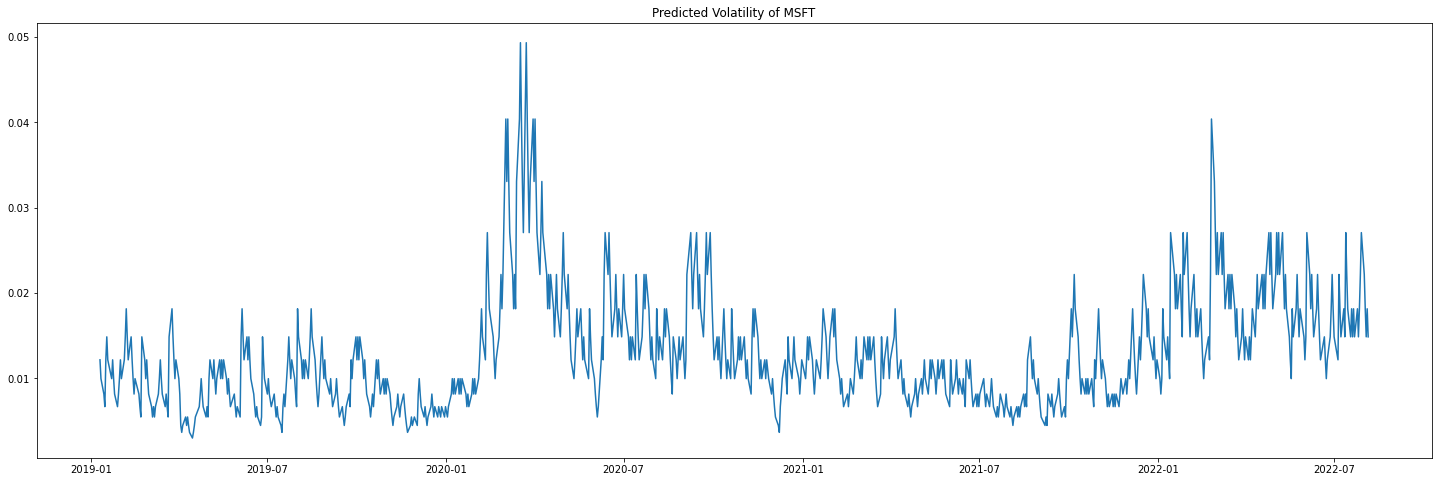

In [9]:
datetime = pd.to_datetime( df["datetime"] )
fig0,ax0 = plt.subplots()
fig0.set_size_inches(25,8)

ax0.plot(datetime[100:1000],pred_sigma[100:1000])
ax0.set_title(f"Predicted Volatility of {ticker}")

## Model Evaluation/Testing

To evaluate or test the model, we can calculate the so called standardized daily return by dividing the actual return by the predicted volatility. If the model's prediction of volatility is good, we expect that the standardized daily return to follow a standard normal distribution. 

The code below calculates the standardized daily return for N time periods. But we only use values after the first 100 steps to test the model as the model needs to learn from the first 100 steps.

In [10]:
# Compute standardized return
Standardized_return=Return[:1000]/pred_sigma[:1000]

/var/folders/br/pwgq2v3x0vg1tnq3nddj9c5r0000gn/T/ipykernel_24217/3143052654.py:2: RuntimeWarning: divide by zero encountered in true_divide
  Standardized_return=Return[:1000]/pred_sigma[:1000]


The error message is due to pred_sigma[0] being 0

In [11]:
## Calculate the KS statistics
KS = stats.kstest(Standardized_return[100:], 'norm')
print(KS)

KstestResult(statistic=0.04482779120044972, pvalue=0.052096960609607446)


The KS statistics was calculated above to test the goodness of fit to a normal distribution. As we can see, the overall normalness is reasonable with a p value greater than 0.05.

In [12]:
## Calculate the kurtosis to check outlier
kurtosis = stats.kurtosis(Standardized_return[100:],fisher=False)

print("Kurtosis:",kurtosis)

Kurtosis: 5.162482312708508


The kurtosis of a standard normal is 3.0. The value above is most certaintly higher than 3.0 as daily return of stock generally has a flatter tail than a normal distribution. This however should be fine for many volatility trading strategy.

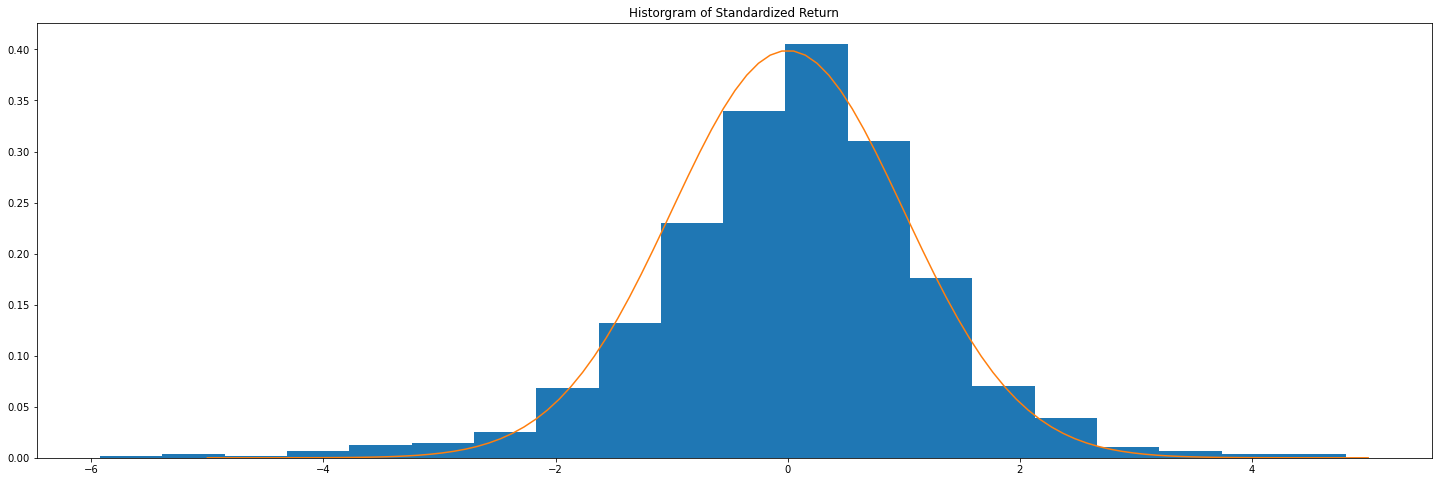

In [13]:
# Plot the historgram of the standardized daily return to verify the normalness visually
fig1,ax1 = plt.subplots()
fig1.set_size_inches(25,8)

x=np.linspace(-5,5,100)
y=norm.pdf(x,0,1)

ax1.hist(Standardized_return[100:1000],density=True,bins=20)

ax1.plot(x,y)
ax1.set_title("Historgram of Standardized Return")

plt.show()

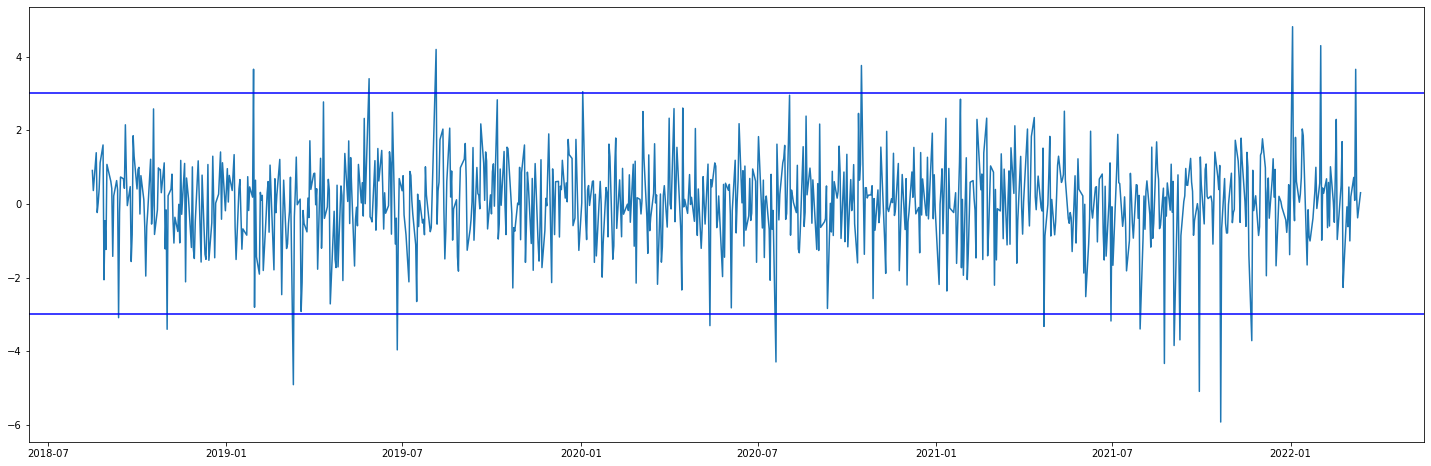

In [14]:
import datetime

datetime = pd.to_datetime( df["datetime"][::-1] )
fig2,ax2 = plt.subplots()
fig2.set_size_inches(25,8)

ax2.plot(datetime[100:1000],Standardized_return[100:1000])

ax2.axhline(y=3,color="b")
ax2.axhline(y=-3,color="b")